In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load the data

To avoid features being derived from other features split the data into subsets *mean_* and *percent_* features.

In [7]:
df = pd.read_csv("./data/processed/raw.csv")
df.drop(["school", "q1", "q3", "grade"], axis=1, inplace=True)
X = df.drop(["name", "event", "place", "all_american", "score"], axis=1)
# Revisit part 2 and scale count
X["year"] /= 4
#X["count"] = X_scaled["count"].copy()

y_score = df["score"]
y_all_am = df["all_american"]

In [275]:
# Prepare scaled data for later
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = list(X.columns[:-1]) # Year scaling is dividing by 4
X_scaled_np = scaler.fit_transform(X.drop(["year"], axis=1))
X_scaled = pd.DataFrame(X_scaled_np, columns=columns)
#X_scaled = pd.concat([df[["all_american", "score"]], X_scaled, df["year"]], axis=1)
X_scaled = pd.concat([X_scaled, df["year"]], axis=1)

## Baseline

Given that there are 24 athletes competing in an event but only 8 placed All-American the completely random change of guessing placement correclty is 1/3.

However, we can make a more intelligent guess if we simply predict the 8 athletes with the best personal records in each event to win. This is our baseline to beat with machine learning.

In [313]:
top_eight_maxes = df.sort_values(["event", "max"], ascending=False).groupby(["event"]).head(8)
print("Baseline accuracy based on best performance: {:.3f}".format(sum(top_eight_maxes["all_american"]) / len(top_eight_maxes)))

Baseline accuracy based on best performance: 0.681


So, if our models can not beat *0.681* we can determine that either 1) we need to collect more data and/or features or 2) this problem is not well suited to machine learning.

## Dimensionality Reduction

### Correlation
Check if any features are highly correlated

In [8]:
X_correlations = df.drop(["name", "place"], axis=1).corr(numeric_only=True)
X_correlations[abs(X_correlations) > 0.4]

,all_american,min,max,mean,std,median,mean_three_recent,mean_three_best,mean_three_worst,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year,score
all_american,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814729
min,NaN,1.000000,0.746160,0.868393,-0.863812,0.839157,0.868393,0.757867,0.958043,-0.742832,-0.834228,NaN,NaN,NaN,NaN
max,NaN,0.746160,1.000000,0.945981,NaN,0.941817,0.945981,0.979613,0.832441,-0.402534,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.868393,0.945981,1.000000,-0.608691,0.994070,1.000000,0.957523,0.951560,-0.633585,-0.566721,NaN,NaN,NaN,NaN
std,NaN,-0.863812,NaN,-0.608691,1.000000,-0.565123,-0.608691,-0.427707,-0.791583,0.805915,0.915533,NaN,NaN,NaN,NaN
median,NaN,0.839157,0.941817,0.994070,-0.565123,1.000000,0.994070,0.956692,0.930132,-0.616570,-0.517846,NaN,NaN,NaN,NaN
mean_three_recent,NaN,0.868393,0.945981,1.000000,-0.608691,0.994070,1.000000,0.957523,0.951560,-0.633585,-0.566721,NaN,NaN,NaN,NaN
mean_three_best,NaN,0.757867,0.979613,0.957523,-0.427707,0.956692,0.957523,1.000000,0.841396,NaN,NaN,NaN,NaN,NaN,NaN
mean_three_worst,NaN,0.958043,0.832441,0.951560,-0.791583,0.930132,0.951560,0.841396,1.000000,-0.786998,-0.789165,NaN,NaN,NaN,NaN
percent_diff_recent_best,NaN,-0.742832,-0.402534,-0.633585,0.805915,-0.616570,-0.633585,NaN,-0.786998,1.000000,0.861893,NaN,0.557427,NaN,NaN


Observations
- The min, max, mean, and median are highly correlated as expected. Consider selecting only one of the four.
- The three *mean_* features highly correlated with min, max, mean, and median so they may not be very descriptive
- The *percent_diff*  features have a strong negative correlation with min, max, mean, median
- The *percent_diff*  features are highly correlated with standard deviation and count which was not expected

In [5]:
# Observe which features correlate best with target
X_correlations["score"]

all_american                 0.814729
min                          0.122397
max                          0.286176
mean                         0.207847
std                          0.034175
median                       0.208468
mean_three_recent            0.207847
mean_three_best              0.268128
mean_three_worst             0.138837
percent_diff_recent_best     0.054832
percent_diff_recent_worst    0.036084
no_mark_rate                -0.148302
count                        0.122951
year                         0.035511
score                        1.000000
Name: score, dtype: float64

In [9]:
# Because min, max, median, and mean_ features are so strongly correlated I will pick only one based on its strongest correlation to target
# Thus by correlation the feature reduced data would be include max, std, percent_diff_recent_best, percent_diff_recnt_worst, no_mark_rate, count, and year
X_fr_correlation = df[["event", "all_american", "score", "max", "std", "percent_diff_recent_best", "percent_diff_recent_worst", "no_mark_rate", "count", "year"]]
X_fr_correlation.head(2)

,event,all_american,score,max,std,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year
0,100,1,1.000000,0.982000,0.011727,0.013292,0.017410,0.0,16,2
1,100,1,0.958333,1.003064,0.011425,0.000230,0.007804,0.0,9,1


### PCA
See if the data scaled or unscaled can be well approximated with fewer dimensions 

In [10]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [11]:
# 99% variance with 5 features features
pca = PCA(n_components=X.shape[1])
pca.fit(X)
np.cumsum(pca.explained_variance_ratio_)

array([0.5363202 , 0.79807738, 0.95851262, 0.97844427, 0.99559703,
       0.99838493, 0.99927716, 0.99973622, 0.99985991, 0.9999376 ,
       0.99998206, 1.        , 1.        ])

In [20]:
# The count variable needs to be scaled as it had a range of 1-75
# 99% variance with 5 features
X_count_scaled = X.copy()
X_count_scaled["count"] = X_scaled["count"].copy()

pca = PCA(n_components=X.shape[1])
pca.fit(X_count_scaled)
np.cumsum(pca.explained_variance_ratio_)

array([0.5363202 , 0.79807738, 0.95851262, 0.97844427, 0.99559703,
       0.99838493, 0.99927716, 0.99973622, 0.99985991, 0.9999376 ,
       0.99998206, 1.        , 1.        ])

In [12]:
# Try PCA with all scaled
# 99% variance with 7 features
pca_scaled = PCA(n_components=X_scaled.shape[1])
pca_scaled.fit(X_scaled)
np.cumsum(pca_scaled.explained_variance_ratio_)

array([0.59059757, 0.79225125, 0.93488583, 0.95773049, 0.97441762,
       0.98670203, 0.99598333, 0.99836088, 0.9992041 , 0.99959171,
       0.99983998, 0.99993166, 0.99998767, 1.        , 1.        ])

In [276]:
# If we perform PCA on the scaled and correlation selected features, we get a much stronger first 3 variances and still 99% after 5
# This means that plotting in 2 dimensions might feasible
pca_corr = PCA(n_components=7)
pca_corr.fit(X_scaled[["max", "std", "percent_diff_recent_best", "percent_diff_recent_worst", "no_mark_rate", "count", "year"]])
np.cumsum(pca_corr.explained_variance_ratio_)

array([0.88032125, 0.93241405, 0.96090668, 0.98509075, 0.99742925,
       0.99944154, 1.        ])

In conclusion, PCA should be highly effective for our data

## Visualization

While not originally planned, because the PCA of features selected by correlation had 93% explained variance with two components I wanted to visualize the PCA data and get a hint if it is clearly seperable 

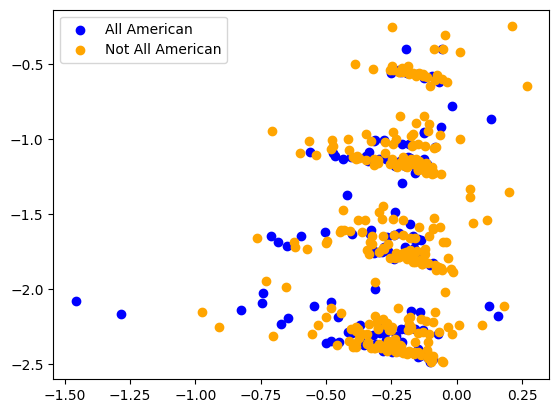

In [277]:
points = X_scaled[["max", "std", "percent_diff_recent_best", "percent_diff_recent_worst", "no_mark_rate", "count", "year"]].to_numpy() @ pca_corr.components_[:,:2]
colors = ["blue" if x == 1 else "orange" for x in y_all_am]
all_am_indexes = y_all_am == 1
plt.scatter(x=points[all_am_indexes,0], y=points[all_am_indexes,1], c="blue")
plt.scatter(x=points[np.invert(all_am_indexes),0], y=points[np.invert(all_am_indexes),1], c="orange")
plt.legend(["All American", "Not All American"])
plt.show()

We can see the two orthogonal axes pretty well here. However, in this projection the data does not appear easily seperable.

## Train Test Split

Splitting for this dataset is mildly tricky. We are assuming that event doesn't matter for predictions but we ultimately need a ranking within the event groups. With there being 18 event groups I want to split the data by 13 events for training and 5 for test which is about 72%, 28% train test split. If we want a validation set we can select 3 events from training to be a validation set.

Additionally, we want to shuffle our data. So, I will randomly select five different 13/5 splits.

In [53]:
from sklearn.model_selection import train_test_split, LeavePGroupsOut, RandomizedSearchCV
import random
import math

In [122]:
# There are 8000 to make this split and I will randomly select five to average their performance for tuning.
groups = df["event"]
lpgo = LeavePGroupsOut(n_groups = 5)
num_splits = lpgo.get_n_splits(X, y_all_am, groups)
random.seed(0)
split_indexes = random.choices(range(num_splits), k=5)

In [281]:
# Verify the data looks shuffled and that the target is stratified to 1/3
# Data cannot be safely put in a big array because the two events with 23 athletes make numbers inconsistent
X_trains = {}
X_tests = {}
y_trains = {}
y_tests = {}

#X_data = X
X_data = X_scaled # sligthly better on SVM

for i, (train_index, test_index) in enumerate(np.array(list(lpgo.split(X_data, y_all_am, groups)), dtype=object)[split_indexes]):
    print("TRAIN:", set([math.floor(x / 24) for x in train_index]), "TEST:", set([math.floor(y / 24) for y in test_index]))
    X_trains[i], X_tests[i] = X_data.iloc[train_index], X_data.iloc[test_index]
    y_trains[i], y_tests[i] = y_all_am.iloc[train_index], y_all_am.iloc[test_index]

TRAIN: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17} TEST: {1, 12, 13, 14, 15, 16}
TRAIN: {0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17} TEST: {3, 4, 11, 12, 13, 14}
TRAIN: {0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15, 16, 17} TEST: {5, 6, 8, 9, 10, 11}
TRAIN: {1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17} TEST: {0, 5, 12, 13, 14, 15}
TRAIN: {0, 1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17} TEST: {2, 4, 7, 9, 10, 11, 12}


In [ ]:
# Need the binary class target for KNN but will try "continuous" score for regression


#
# NEED TO SPLIT ON ORIGINAL DF TO RE-MAP NAMES AND EVENTS
#

# Use the same random_state to keep data consistently split
# Stratify on df["all_american"] because data should be split into 1/3rd all americans, 2/3rds not
X_train_details, X_test_details, _, _ = train_test_split(df[["name", "all_american", "place", "score"]], y_score, test_size=4/18, random_state=0, stratify=df["all_american"])
X_train, X_test, y_score_train, y_score_test = train_test_split(X_scaled, y_score, test_size=4/18, random_state=0, stratify=df["all_american"])
_, _, y_all_am_train, y_all_am_test = train_test_split(X_scaled, y_all_am, test_size=4/18, random_state=0, stratify=df["all_american"])
assert sum([1 if x > 0.7 else 0 for x in y_score_train] == y_all_am_train) # assert we got data in the same order thus we don't need second Xs

# see data shape and confirm that label is stratified appropriately
print(X_train.shape, X_test.shape)
print(sum(y_all_am_train)/len(y_all_am_train), sum(y_all_am_test)/len(y_all_am_test))

In [7]:
X_train_details[:5]

,name,all_american,place,score
54,JEVAUGHN POWELL,1,7,0.750000
196,QUIVELL JORDAN-BACOT,1,5,0.833333
89,SAMUEL VOELZ,0,18,0.291667
8,SHAUN MASWANGANYI,0,9,0.666667
423,BRADEN PRESSER,0,18,0.291667


In [15]:
X_train[:5]

,all_american,score,min,max,mean,std,median,mean_three_recent,mean_three_best,mean_three_worst,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year
54,1,0.750000,0.860270,0.870584,0.829370,0.173476,0.818992,0.829370,0.868890,0.836297,0.173024,0.105890,0.000000,0.222222,2
196,1,0.833333,0.248442,0.842279,0.785206,0.540178,0.816317,0.785206,0.829330,0.560194,0.190828,0.490923,0.000000,0.486111,4
89,0,0.291667,0.877534,0.846894,0.878640,0.106611,0.886092,0.878640,0.862780,0.868461,0.079926,0.100240,0.222222,0.375000,4
8,0,0.666667,0.941199,0.966217,0.956703,0.085778,0.953149,0.956703,0.947334,0.945212,0.072652,0.056799,0.000000,0.250000,2
423,0,0.291667,0.512907,0.262090,0.204678,0.366347,0.246709,0.204678,0.244741,0.386869,0.358375,0.272105,0.000000,0.166667,2


In [13]:
df.iloc[[54, 196, 89, 8, 423]]

,name,event,place,all_american,min,max,mean,std,median,mean_three_recent,mean_three_best,mean_three_worst,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year,score
54,JEVAUGHN POWELL,400,7,1,0.884405,0.971919,0.930996,0.024088,0.931440,0.930996,0.959094,0.895802,0.029731,0.038531,0.000000,19,2,0.750000
196,QUIVELL JORDAN-BACOT,400H,5,1,0.513543,0.965107,0.918892,0.069295,0.930721,0.918892,0.949515,0.768204,0.032780,0.178636,0.000000,38,4,0.833333
89,SAMUEL VOELZ,800,18,0,0.894869,0.966217,0.944500,0.015845,0.949469,0.944500,0.957615,0.910666,0.013789,0.036475,0.066667,30,4,0.291667
8,SHAUN MASWANGANYI,100,9,0,0.933460,0.994934,0.965895,0.013276,0.967488,0.965895,0.978088,0.946136,0.012544,0.020668,0.000000,21,2,0.666667
423,BRADEN PRESSER,JT,18,0,0.673850,0.825477,0.759783,0.047865,0.777666,0.759783,0.807969,0.688103,0.061471,0.099013,0.000000,15,2,0.291667


## Model 1 - KNN

## Model 2 - Decision Tree

## Model 3 - SVM

We can make two simple arguments about correctness of predictons before training any model. We know, that the predictions above 1 lose meaning. Secondly, our labels are uniformly distributed so our predictions should be as well.

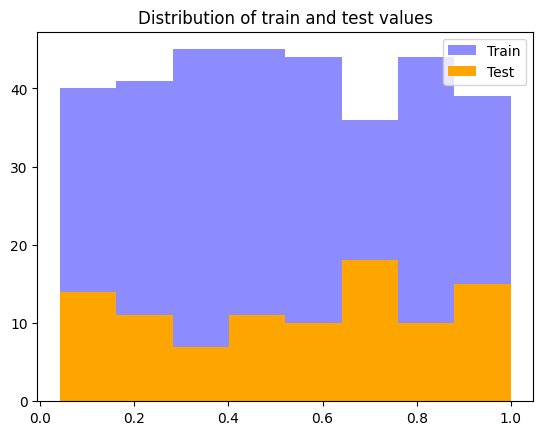

In [37]:
plt.hist(y_score_train, bins=8, alpha=0.45, color='blue', label="Train")
plt.hist(y_score_test, bins=8, alpha=1, color='orange', label="Test")
plt.legend()
plt.title("Distribution of train and test values")
plt.show()

In [291]:
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay
# Try with score as target and SVR

In [288]:
avg_accuracy, avg_f1, avg_percent_allam, avg_correct_allam = 0, 0, 0, 0
for X_train, y_train in zip(X_trains.values(), y_trains.values()):

    # Train the model
    svm = SVC(C=1, kernel="poly", degree=5, probability=True, class_weight='balanced')
    #svm = SVC(kernel="linear", probability=True, class_weight='balanced') # C=1, kernel=poly, degree=5 seems good
    svm.fit(X_train, y_train)

    # Predictions to get metrics
    predictions = svm.predict(X_train)
    inverse_predictions = [0 if p == 1 else 1 for p in predictions]

    # Metrics
    avg_accuracy += accuracy_score(predictions, y_train)
    avg_f1 += f1_score(predictions, y_train)
    avg_percent_allam += sum(predictions) / len(predictions)

    # The most important prediction
    temp = df.iloc[X_train.index][["name", "event", "place", "all_american"]]
    temp["prob_all_am"] = svm.predict_proba(X_train)[:,1]
    mapped_predictions = temp.sort_values(["event", "prob_all_am"], ascending=False).groupby(["event"]).head(8)
    avg_correct_allam += sum(mapped_predictions["all_american"]) / len(mapped_predictions)
    # print("Accuracy: {:.4f}".format(accuracy_score(predictions, y_train)))
    # print("F1 Score: {:.4f}".format(f1_score(predictions, y_train)))
    # print("Percent all american {:.4f}\n".format(sum(predictions) / len(predictions)))

avg_accuracy /= 5
avg_f1 /= 5
avg_percent_allam /= 5
avg_correct_allam /= 5
print("Average accuracy: {:.4f}".format(avg_accuracy))
print("Aveage F1 Score: {:.4f}".format(avg_f1))
print("Average percent of predictions to be all-american {:.4f}".format(avg_percent_allam))
print("Average percent of corectly predicted all-american {:.4f}\n".format(avg_correct_allam))

Average accuracy: 0.6598
Aveage F1 Score: 0.5769
Average percent of predictions to be all-american 0.4691
Average percent of corectly predicted all-american 0.6231



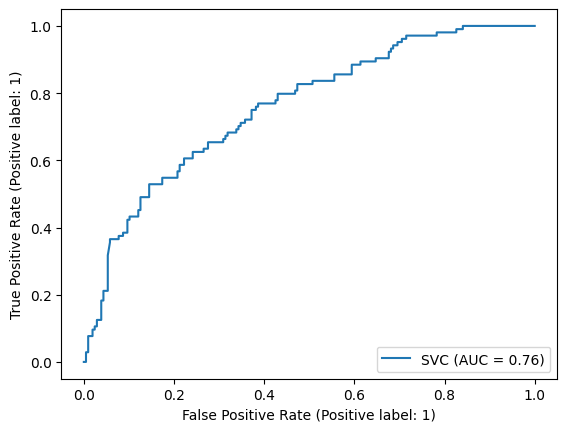

In [296]:
# Most recent classifier
RocCurveDisplay.from_estimator(svm, X_train, y_train)

In [243]:
print(svm.classes_) # to confirm second class is 1
temp = X_train.copy()
temp = df.iloc[temp.index][["name", "event", "place", "all_american"]]
temp["prob_all_am"] = svm.predict_proba(X_train)[:,1]
# Count the number of top 8 predictions that were correct
temp.sort_values(["event", "prob_all_am"], ascending=False).groupby(["event"]).head(2)

[0 1]


,name,event,place,all_american,prob_all_am
311,EMMANUEL IHEMEJE,TJ,2,1,0.456490
310,CHENGETAYI MAPAYA,TJ,1,1,0.450963
334,ADRIAN PIPERI,SP,1,1,0.521964
335,TURNER WASHINGTON,SP,2,1,0.500000
263,CLAYTON FRITSCH,PV,2,1,0.533377
270,ZACH BRADFORD,PV,9,0,0.508653
410,CHINECHEREM PROSPER NNAMDI,JT,5,1,0.320500
406,MARC MINICHELLO,JT,1,1,0.272518
391,JAKE NORRIS,HT,10,0,0.294829
386,MICHAEL BRYAN,HT,5,1,0.276575


In [119]:
# svm = SVR(kernel="poly", degree=5)
# svm.fit(X_train, y_score_train)
# plt.hist(svm.predict(X_train), bins=8)
# plt.show()

In [133]:
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error
predictions = svm.predict(X_train)
sorted(predictions, reverse=True)[:10]
# for metric in [max_error, mean_squared_error, mean_absolute_error]:
#     print(metric(predictions, y_score_train))


[1.1004778278400194,
 1.1002894115507702,
 1.1001437810721248,
 1.0998833665654135,
 1.099821971593929,
 1.0996933983397228,
 1.0931263409963858,
 1.068980302781321,
 1.0598735614186148,
 1.055958833548002]

In [133]:
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error
predictions = svm.predict(X_train)
sorted(predictions, reverse=True)[:10]
# for metric in [max_error, mean_squared_error, mean_absolute_error]:
#     print(metric(predictions, y_score_train))


[1.1004778278400194,
 1.1002894115507702,
 1.1001437810721248,
 1.0998833665654135,
 1.099821971593929,
 1.0996933983397228,
 1.0931263409963858,
 1.068980302781321,
 1.0598735614186148,
 1.055958833548002]